# Image Stitching (Python)

## Usage
This code snippet provides an overall code structure and some interactive plot interfaces for the Stitching Pairs of Images section of MP 3. In main function, we outline the required functionalities step by step. Feel free to make modifications on the starter code if it's necessary.

## Package installation
- `opencv`
- `numpy`
- `skimage`
- `scipy`

# Common imports

In [1]:
import numpy as np
import skimage
import cv2
import matplotlib.pyplot as plt
from scipy.spatial import distance
import scipy

In [3]:
pip install scikit-image

     --------------------------------------- 23.7/23.7 MB 11.9 MB/s eta 0:00:00
     --------------------------------------- 42.5/42.5 MB 12.4 MB/s eta 0:00:00
     ---------------------------------------- 3.4/3.4 MB 12.7 MB/s eta 0:00:00
  Using cached networkx-3.0-py3-none-any.whl (2.0 MB)
     ------------------------------------- 218.7/218.7 kB 13.9 MB/s eta 0:00:00
     ---------------------------------------- 4.2/4.2 MB 16.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: C:\Users\Genghis\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


# Helper functions

In [2]:
def imread(fname):
    """
    read image into np array from file
    """
    return skimage.io.imread(fname)

def imread_bw(fname):
    """
    read image as gray scale format
    """
    return cv2.cvtColor(imread(fname), cv2.COLOR_BGR2GRAY)

def imshow(img):
    """
    show image
    """
    skimage.io.imshow(img)
    
def get_sift_data(img):
    """
    detect the keypoints and compute their SIFT descriptors with opencv library
    """
    sift = cv2.SIFT_create()
    kp, des = sift.detectAndCompute(img, None)
    return kp, des

def plot_inlier_matches(ax, img1, img2, inliers):
    """
    plot the match between two image according to the matched keypoints
    :param ax: plot handle
    :param img1: left image
    :param img2: right image
    :inliers: x,y in the first image and x,y in the second image (Nx4)
    """
    res = np.hstack([img1, img2])
    ax.set_aspect('equal')
    ax.imshow(res, cmap='gray')
    
    ax.plot(inliers[:,0], inliers[:,1], '+r')
    ax.plot(inliers[:,2] + img1.shape[1], inliers[:,3], '+r')
    ax.plot([inliers[:,0], inliers[:,2] + img1.shape[1]],
            [inliers[:,1], inliers[:,3]], 'r', linewidth=0.4)
    ax.axis('off')

# Your implementations

In [3]:
def get_best_matches(img1, img2, num_matches):
    kp1, des1 = get_sift_data(img1)
    kp2, des2 = get_sift_data(img2)
    kp1, kp2 = np.array(kp1), np.array(kp2)

    # Find distance between descriptors in images
    dist = scipy.spatial.distance.cdist(des1, des2, 'sqeuclidean')
    
    # Write your code to get the matches according to dist
    # <YOUR CODE>
    sorted_y_ind, sorted_x_ind = np.unravel_index(np.argsort(dist, axis=None), dist.shape)
    
    # Keep only top-k matches
    top_k = num_matches

    ret_list = []

    for i in range(top_k):
        kp1_x = kp1[sorted_y_ind[i]].pt[0]
        kp1_y = kp1[sorted_y_ind[i]].pt[1]
        kp2_x = kp2[sorted_x_ind[i]].pt[0]
        kp2_y = kp2[sorted_x_ind[i]].pt[1]

        ret_list.append((kp1_x, kp1_y, kp2_x, kp2_y))

    data = np.array(ret_list)
    
    return data

def ransac(data, trials=100):
    """
    write your ransac code to find the best model, inliers, and residuals
    """
    best_inliners_num = 0
    best_H = None
    best_error = None
    
    for iter_t in range(trials):
        selected_idx = np.random.choice(np.arange(data.shape[0]), size=(4,), replace=False)

        kp1_subset = data[selected_idx, :2]
        kp2_subset = data[selected_idx, 2:]

        estimated_H = compute_homography(kp1_subset, kp2_subset)

        estimated_point = np.append(data[:, :2], np.ones((data.shape[0], 1)), axis=1) @ estimated_H.T
        estimated_point[:,:] = estimated_point[:,:] / estimated_point[:,2:]
        estimated_point = estimated_point[:,:2]

        pixel_dist = np.sum(np.square(estimated_point - data[:, 2:]), axis=1)

        inliers_cnt = np.sum(pixel_dist < 10)
        
        if inliers_cnt > best_inliners_num:
            best_inliners_num = inliers_cnt
            best_H = estimated_H
            best_error = pixel_dist
    
    return best_H, best_inliners_num, best_error

def compute_homography(pts1, pts2):
    '''
    pts1 and pts2 are 4x2 matrices for 4 points in homogeneous
    coordinates. 
    
    Output: H s.t. pts2~=H@pts1
    '''
    n_pts = 4

    A = np.zeros((n_pts * 2, 9))

    for i in range(n_pts * 2):
        ptr_idx = i // 2
        if i % 2 == 0:
            # even row
            A[i, 0] = -pts1[ptr_idx, 0]
            A[i, 1] = -pts1[ptr_idx, 1]
            A[i, 2] = -1

            A[i, 6] = pts1[ptr_idx, 0] * pts2[ptr_idx, 0]
            A[i, 7] = pts1[ptr_idx, 1] * pts2[ptr_idx, 0]
            A[i, 8] = pts2[ptr_idx, 0]
        else:
            # odd rows
            A[i, 3] = -pts1[ptr_idx, 0]
            A[i, 4] = -pts1[ptr_idx, 1]
            A[i, 5] = -1
            A[i, 6] = pts1[ptr_idx, 0] * pts2[ptr_idx, 1]
            A[i, 7] = pts1[ptr_idx, 1] * pts2[ptr_idx, 1]
            A[i, 8] = pts2[ptr_idx, 1]
    
    u, s, vh = np.linalg.svd(A)
    H = vh[-1]
    
    return H.reshape((3, 3))

def warp_images(img1, img2, best_H):
    """
    write your code to stitch images together according to the homography
    
    Assume img2 is to the right of img1
    """
    canvas_width = img1.shape[1] + img2.shape[1]
    canvas_height = img1.shape[0] + img2.shape[0]
    img2_T = np.array([[1, 0, img1.shape[1]], [0, 1, 0], [0, 0, 1]]).astype(float)

    print(img1.shape)
    print(img2.shape)
    print(img2_T.shape)
    print(len(best_H))
    # TO DO: warp and blend the two images
    projected_img1 = cv2.warpPerspective(img1, img2_T @ best_H, (canvas_width, canvas_height))
    projected_img2 = cv2.warpPerspective(img2, img2_T, (canvas_width, canvas_height))
    
    empty_idx = (np.sum(projected_img2 == 0, axis=2) == 3)
    canvas = projected_img2.copy()
    canvas[empty_idx,:] = projected_img1[empty_idx,:]
    
    return canvas

# Main functions

#### Load images

In [4]:
img1 = imread('./stitch/left.jpg')
img2 = imread('./stitch/right.jpg')

FileNotFoundError: No such file: 'c:\Users\Genghis\Downloads\stitch\left.jpg'

#### Part (3) compute and display the initial SIFT matching result

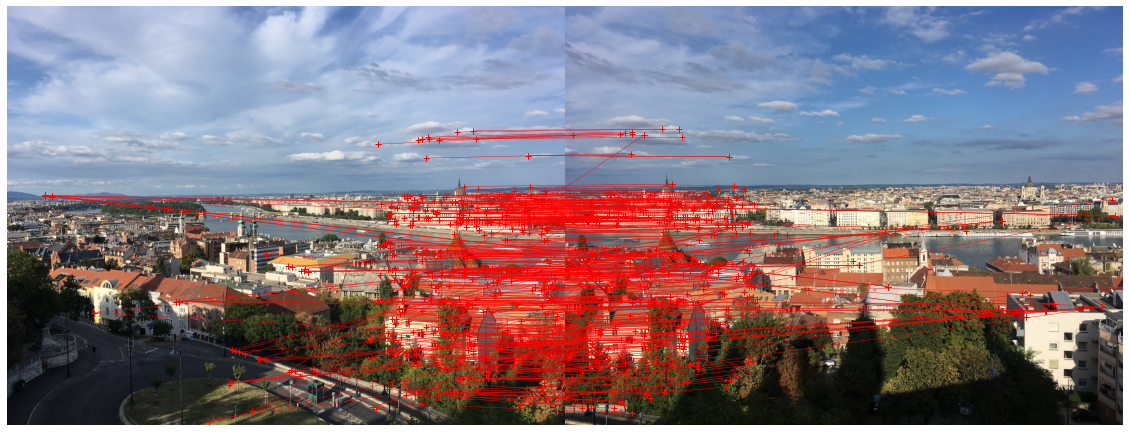

In [54]:
data = get_best_matches(img1, img2, 500)
fig, ax = plt.subplots(figsize=(20,10))
plot_inlier_matches(ax, img1, img2, data)
fig.savefig('sift_match.pdf', bbox_inches='tight')

#### Part (4) performn RANSAC to get the homography and inliers

In [60]:
# display the inlier matching, report the average residual
# <YOUR CODE>
best_H, max_inliers, best_model_errors = ransac(data)
print("Median residual:", np.median(best_model_errors))
print("Average residual:", np.average(best_model_errors))
print("Inliers:", max_inliers)
# fig.savefig('ransac_match.pdf', bbox_inches='tight')

Median residual: 1.043854158832399
Average residual: 217863.39284902962
Inliers: 408


#### Part (5) warp images to stitch them together

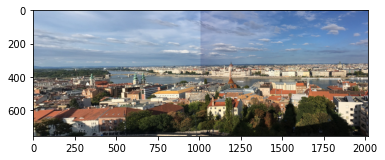

True

In [88]:
# display and report the stitching results
im = warp_images(img1, img2, best_H)
# Manual cropping
im = im[:img2.shape[0]]
plt.imshow(im)
plt.show()
cv2.imwrite('stitched_images.jpg', im[:,:,::-1]*255., 
            [int(cv2.IMWRITE_JPEG_QUALITY), 90])